# CR3BP : Lagrange Points

This notebook computes the five Lagrange points (L1–L5) in the non-dimensional rotating barycentric CR3BP frame and prints both non-dimensional and physical (km) coordinates.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import constants as const
from astropy import units as u

## System defaults (Earth–Moon)

Moon mass is defined manually since it is not included in `astropy.constants` by default.

In [2]:
PRIMARY_NAME = "Earth"
SECONDARY_NAME = "Moon"

M_PRIMARY = const.M_earth
M_SECONDARY = 7.34767309e22 * u.kg

# Mean Earth–Moon distance
D12 = 3.84405e8 * u.m

mu = (M_SECONDARY / (M_PRIMARY + M_SECONDARY)).decompose().value
print(f"mu = {mu:.12f} for {PRIMARY_NAME}-{SECONDARY_NAME}")

# Primary/secondary positions in barycentric non-dimensional coordinates
x1_nd, y1_nd = -mu, 0.0
x2_nd, y2_nd = 1.0 - mu, 0.0

mu = 0.012153663633 for Earth-Moon


## Lagrange point solver

Uses Newton's method on \(\partial \Omega / \partial x\) along the x-axis for L1/L2/L3 and analytic equilateral geometry for L4/L5.


In [3]:
def dOmega_dx_on_x_axis(x: float, mu: float) -> float:
    """dOmega/dx on x-axis (y=z=0) in rotating CR3BP barycentric coords."""
    x1 = -mu
    x2 = 1.0 - mu
    r1 = abs(x - x1)
    r2 = abs(x - x2)
    if r1 == 0.0 or r2 == 0.0:
        return np.inf
    return x - (1.0 - mu) * (x - x1) / r1**3 - mu * (x - x2) / r2**3


def d2Omega_dx2_numeric(x: float, mu: float, h: float = 1e-8) -> float:
    return (dOmega_dx_on_x_axis(x + h, mu) - dOmega_dx_on_x_axis(x - h, mu)) / (2.0 * h)


def newton_solve_collinear(x0: float, mu: float, tol: float = 1e-14, max_iter: int = 80) -> float:
    x = x0
    for _ in range(max_iter):
        f = dOmega_dx_on_x_axis(x, mu)
        fp = d2Omega_dx2_numeric(x, mu)
        if not np.isfinite(f) or not np.isfinite(fp) or fp == 0.0:
            break
        x_new = x - f / fp
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    raise RuntimeError("Newton solve failed for a collinear Lagrange point.")


def compute_lagrange_points(mu: float) -> dict:
    """Return L1..L5 as dict of {name: np.array([x, y])}."""
    # Initial guesses for collinear points using Hill's approximations
    gamma0 = (mu / 3.0) ** (1.0 / 3.0)
    xL1 = newton_solve_collinear(1.0 - mu - gamma0, mu)
    xL2 = newton_solve_collinear(1.0 - mu + gamma0, mu)
    xL3 = newton_solve_collinear(-1.0 - (5.0 * mu / 12.0), mu)

    xL4 = 0.5 - mu
    yL4 = np.sqrt(3.0) / 2.0
    xL5 = xL4
    yL5 = -yL4

    return {
        "L1": np.array([xL1, 0.0]),
        "L2": np.array([xL2, 0.0]),
        "L3": np.array([xL3, 0.0]),
        "L4": np.array([xL4, yL4]),
        "L5": np.array([xL5, yL5]),
    }


L_points = compute_lagrange_points(mu)


In [4]:
print("Non-dimensional Lagrange points (barycentric rotating frame):")
for name, xy in L_points.items():
    print(f"  {name}: x={xy[0]: .12f}, y={xy[1]: .12f}")

print("\nPhysical coordinates (km) in the same rotating barycentric frame:")
D_km = D12.to_value(u.km)
print(f"  {PRIMARY_NAME:>8}: x={x1_nd * D_km: .3f} km, y={y1_nd * D_km: .3f} km")
print(f"  {SECONDARY_NAME:>8}: x={x2_nd * D_km: .3f} km, y={y2_nd * D_km: .3f} km")
for name, xy in L_points.items():
    print(f"  {name:>8}: x={xy[0] * D_km: .3f} km, y={xy[1] * D_km: .3f} km")


Non-dimensional Lagrange points (barycentric rotating frame):
  L1: x= 0.836899981354, y= 0.000000000000
  L2: x= 1.155694002609, y= 0.000000000000
  L3: x=-1.005063928245, y= 0.000000000000
  L4: x= 0.487846336367, y= 0.866025403784
  L5: x= 0.487846336367, y=-0.866025403784

Physical coordinates (km) in the same rotating barycentric frame:
     Earth: x=-4671.929 km, y= 0.000 km
      Moon: x= 379733.071 km, y= 0.000 km
        L1: x= 321708.537 km, y= 0.000 km
        L2: x= 444254.553 km, y= 0.000 km
        L3: x=-386351.599 km, y= 0.000 km
        L4: x= 187530.571 km, y= 332904.495 km
        L5: x= 187530.571 km, y=-332904.495 km


## Plot


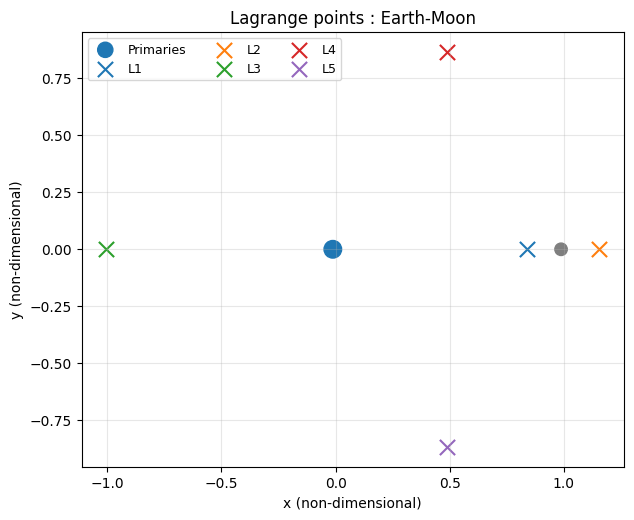

In [5]:
# Non-dimensional plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter([x1_nd, x2_nd], [0, 0], s=[160, 80], c=["tab:blue", "tab:gray"], label="Primaries")
for name, xy in L_points.items():
    ax.scatter([xy[0]], [xy[1]], marker="x", s=120, label=name)
ax.set_aspect("equal", "box")
ax.grid(True, alpha=0.3)
ax.set_xlabel("x (non-dimensional)")
ax.set_ylabel("y (non-dimensional)")
ax.set_title(f"Lagrange points : {PRIMARY_NAME}-{SECONDARY_NAME}")
ax.legend(ncol=3, fontsize=9)
plt.show()


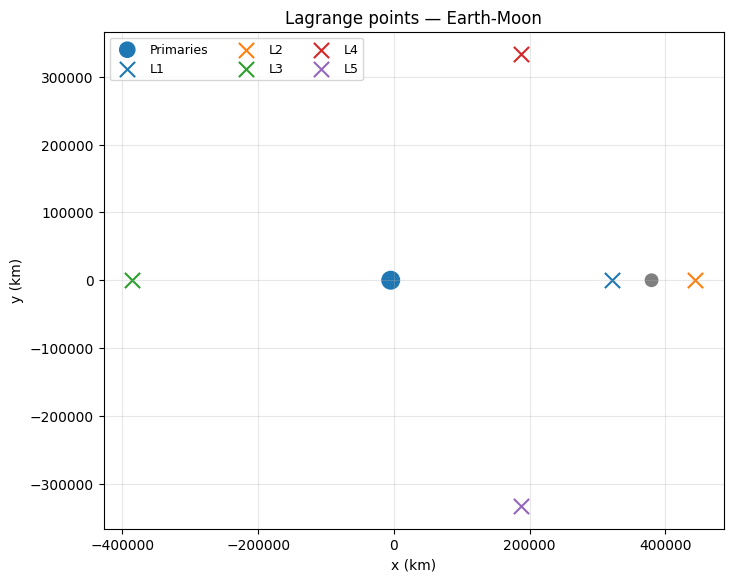

In [6]:
# Physical scale plot
D_km = D12.to_value(u.km)

x1_km, y1_km = x1_nd * D_km, 0.0
x2_km, y2_km = x2_nd * D_km, 0.0

fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter([x1_km, x2_km], [y1_km, y2_km], s=[160, 80], c=["tab:blue", "tab:gray"], label="Primaries")

for name, xy_nd in L_points.items():
    ax.scatter([xy_nd[0] * D_km], [xy_nd[1] * D_km], marker="x", s=120, label=name)

ax.set_aspect("equal", "box")
ax.grid(True, alpha=0.3)
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_title(f"Lagrange points — {PRIMARY_NAME}-{SECONDARY_NAME}")
ax.legend(ncol=3, fontsize=9)
plt.show()